#**Aprendizaje Automático** - 2023
# Clase ~10~ ~11~ 12: El tallercito de redes neuronales

*Trabajaron en esta notebook: Sofia Del Pozo, Diego Onna, Gastón Bujía*

## Contenidos

* Introducción a Keras

* Feedforward

* Backpropagation 

* Entrenamiento, epochs, batch

# Repaso de Redes Neuronales

Veamos un poco más sobre las decisiones que tomas las redes jugando un poco en el [Playground de TensorFlow](https://playground.tensorflow.org/#activation=sigmoid&batchSize=10&dataset=gauss&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4&seed=0.98534&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false).

Les dejamos una [lista de videos](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi) (en Inglés) que pueden ver para profundizar un poco en el funcionamiento de las redes y como aprendemos sus parametros

# Clasificación de datos estructurados con Keras

A continuación veremos cómo realizar una clasificación de datos estructurados, utilizando un archivo CSV sin procesar. Nuestros datos incluyen características tanto numéricas como categóricas. Utilizaremos capas de preprocesamiento de Keras para normalizar las características numéricas y vectorizar las características categóricas (usar versión de TensorFlow 2.5 o mayor).

### Preparando la data

Descargaremos [datos](https://archive.ics.uci.edu/ml/datasets/heart+Disease) proporcionados la Fundación Cleveland Clinic para Enfermedades Cardíacas. Es un archivo CSV con 303 filas. Cada fila contiene información sobre un paciente (una muestra), y cada columna describe un atributo del paciente (una característica). Utilizamos las características para predecir si un paciente tiene una enfermedad cardíaca (clasificación binaria).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Cargamos la data
file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
dataframe = pd.read_csv(file_url)

In [3]:
dataframe.shape

(303, 14)

In [4]:
dataframe.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


La última columna, "target", indica si el paciente tiene una enfermedad cardíaca (1) o no (0).

Dividimos los datos en un conjunto de entrenamiento y validación:

In [5]:
val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)

print("Using %d samples for training and %d for validation" % (len(train_dataframe), len(val_dataframe)))

Using 242 samples for training and 61 for validation



Generemos objetos [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) para cada dataframe. *Sugerencia*: Para entender bien lo que esta sucediendo, pueden ver un poco que hace la función `from_tensor_slices`.

In [6]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

Cada Dataset proporciona una tupla (input, target), donde input es un diccionario de características y target es el valor 0 o 1:





In [7]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'age': <tf.Tensor: shape=(), dtype=int64, numpy=35>, 'sex': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'cp': <tf.Tensor: shape=(), dtype=int64, numpy=4>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=126>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=282>, 'fbs': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'restecg': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=156>, 'exang': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>, 'slope': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'ca': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'thal': <tf.Tensor: shape=(), dtype=string, numpy=b'reversible'>}
Target: tf.Tensor(0, shape=(), dtype=int64)


Agrupamos los conjuntos de datos por batches:

In [8]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

### Preprocesamiento de características con capas de Keras


Las siguientes características son características categóricas codificadas como enteros:

* sex
* cp
* fbs
* restecg
* exang
* ca

Codificaremos estas características utilizando **one-hot encoding**. Tenemos dos opciones:

* Usar CategoryEncoding(), que requiere conocer el rango de valores de entrada y generará un error en entradas fuera del rango.

* Usar IntegerLookup(), que creará una tabla de búsqueda para las entradas y reservará un índice de salida para valores de entrada desconocidos.

Para este ejemplo, queremos una solución simple que maneje las entradas fuera de rango durante la inferencia, por lo que usaremos IntegerLookup().

También tenemos una característica categórica codificada como una cadena: thal. Crearemos un índice de todas las posibles características y codificaremos la salida utilizando la capa StringLookup().

Finalmente, las siguientes características son características numéricas continuas:

* age
* trestbps
* chol
* thalach
* oldpeak
* slope

Para cada una de estas características, utilizaremos una capa de Normalization() para asegurarnos de que la media de cada característica sea 0 y su desviación estándar sea 1.

A continuación, definimos 3 funciones auxiliares para realizar las operaciones:

* encode_numerical_feature para aplicar normalización de características a nivel de característica a características numéricas.

* encode_string_categorical_feature para convertir primero las entradas de cadena en índices enteros, y luego codificar en one-hot estos índices enteros.

* encode_integer_categorical_feature para codificar en one-hot características categóricas enteras.

In [9]:
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup

def encode_numerical_feature(feature, name, dataset):
    # Crea una capa de Normalization para nuestra característica
    normalizer = Normalization()

    # Prepara un Dataset que solo produzca nuestra característica
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Aprende las estadísticas de los datos
    normalizer.adapt(feature_ds)

    # Normaliza la característica de entrada
    encoded_feature = normalizer(feature)
    return encoded_feature

def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Crea una capa de lookup que convierta las cadenas en índices enteros
    lookup = lookup_class(output_mode="binary")

    # Prepara un Dataset que solo produzca nuestra característica
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Aprende el conjunto de posibles valores de cadena y les asigna un índice entero fijo
    lookup.adapt(feature_ds)

    # Convierte la entrada de cadena en índices enteros
    encoded_feature = lookup(feature)
    return encoded_feature

Ahora debemos aplicar estas transformaciones a los datos para poder pasarlo al tipo de datos que necesita Keras y TensorFlow.

In [10]:
# Features categóricas codificadas como enteros
sex = keras.Input(shape=(1,), name="sex", dtype="int64")
cp = keras.Input(shape=(1,), name="cp", dtype="int64")
fbs = keras.Input(shape=(1,), name="fbs", dtype="int64")
restecg = keras.Input(shape=(1,), name="restecg", dtype="int64")
exang = keras.Input(shape=(1,), name="exang", dtype="int64")
ca = keras.Input(shape=(1,), name="ca", dtype="int64")

# Features feature codificadas como string
thal = keras.Input(shape=(1,), name="thal", dtype="string")

# Features numericas
age = keras.Input(shape=(1,), name="age")
trestbps = keras.Input(shape=(1,), name="trestbps")
chol = keras.Input(shape=(1,), name="chol")
thalach = keras.Input(shape=(1,), name="thalach")
oldpeak = keras.Input(shape=(1,), name="oldpeak")
slope = keras.Input(shape=(1,), name="slope")

all_inputs = [
    sex,
    cp,
    fbs,
    restecg,
    exang,
    ca,
    thal,
    age,
    trestbps,
    chol,
    thalach,
    oldpeak,
    slope,
]

# Features categoricas (enteros)
sex_encoded = encode_categorical_feature(sex, "sex", train_ds, False)
cp_encoded = encode_categorical_feature(cp, "cp", train_ds, False)
fbs_encoded = encode_categorical_feature(fbs, "fbs", train_ds, False)
restecg_encoded = encode_categorical_feature(restecg, "restecg", train_ds, False)
exang_encoded = encode_categorical_feature(exang, "exang", train_ds, False)
ca_encoded = encode_categorical_feature(ca, "ca", train_ds, False)

# Features categoricas (strings)
thal_encoded = encode_categorical_feature(thal, "thal", train_ds, True)

# Features numericas
age_encoded = encode_numerical_feature(age, "age", train_ds)
trestbps_encoded = encode_numerical_feature(trestbps, "trestbps", train_ds)
chol_encoded = encode_numerical_feature(chol, "chol", train_ds)
thalach_encoded = encode_numerical_feature(thalach, "thalach", train_ds)
oldpeak_encoded = encode_numerical_feature(oldpeak, "oldpeak", train_ds)
slope_encoded = encode_numerical_feature(slope, "slope", train_ds)

all_features = layers.concatenate(
    [
        sex_encoded,
        cp_encoded,
        fbs_encoded,
        restecg_encoded,
        exang_encoded,
        slope_encoded,
        ca_encoded,
        thal_encoded,
        age_encoded,
        trestbps_encoded,
        chol_encoded,
        thalach_encoded,
        oldpeak_encoded,
    ]
)

### Contruir el modelo: enfoque funcional

Existen multiples maneras de construir modelos en Keras y cuales utilicemos dependerá de que tipo de modelo y tipo de datos tengamos. Nosotros utilizaremos el módulo más general que es el módulo funcional, en el cual construiremos el modelo capa a capa como una función usando como base la clase [`Model`](https://keras.io/api/models/model/) y las capas que nos proporciona el módulo [`layers`](https://keras.io/api/layers/).

**Observación** Otro módulo importante que nos proporciona Keras es **[Sequential](https://keras.io/guides/sequential_model/)** para construir una [*Red Feedfoward*](https://en.wikipedia.org/wiki/Feedforward_neural_network) que tenga de entrada un tensor y como salida otro tensor.

In [11]:
# Primero creamos la primer capa oculta que se conectará con la entrada que tiene dimension igual a all_features.shape
# La forma de hacerlo es crear una nueva funcion x que sear aplicar la capa a la entrada
# En este caso será una capa densa de 32 unidades con activación ReLU
hidden1 = layers.Dense(units=32, activation="relu")(all_features)

# Segundo agregamos una nueva capa de otro estilo, llamada dropout que no es tecnicamente una capa sino una etapa de regularizacion
droput1 = layers.Dropout(0.5)(hidden1)

# Finalmente agregamos una última capa con una salida solamente ya que se trata de un problema de clasificación binaria
output = layers.Dense(1, activation="sigmoid")(droput1)

Ahora debemos crear una instancia del modelo funcional. Aquí, inputs se refiere a la capa de entrada definida en el paso anterior, y outputs es la capa de salida del modelo.

In [12]:
model = keras.Model(all_inputs, output)

Ahora debemos proceder a *compilar* el modelo, en este paso, se define el optimizador utilizado para ajustar los pesos del modelo, la función de pérdida que se utilizará para evaluar la calidad del modelo y las métricas que se desean calcular durante el entrenamiento.

In [13]:
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

Visualizamos el grafo de conectividad

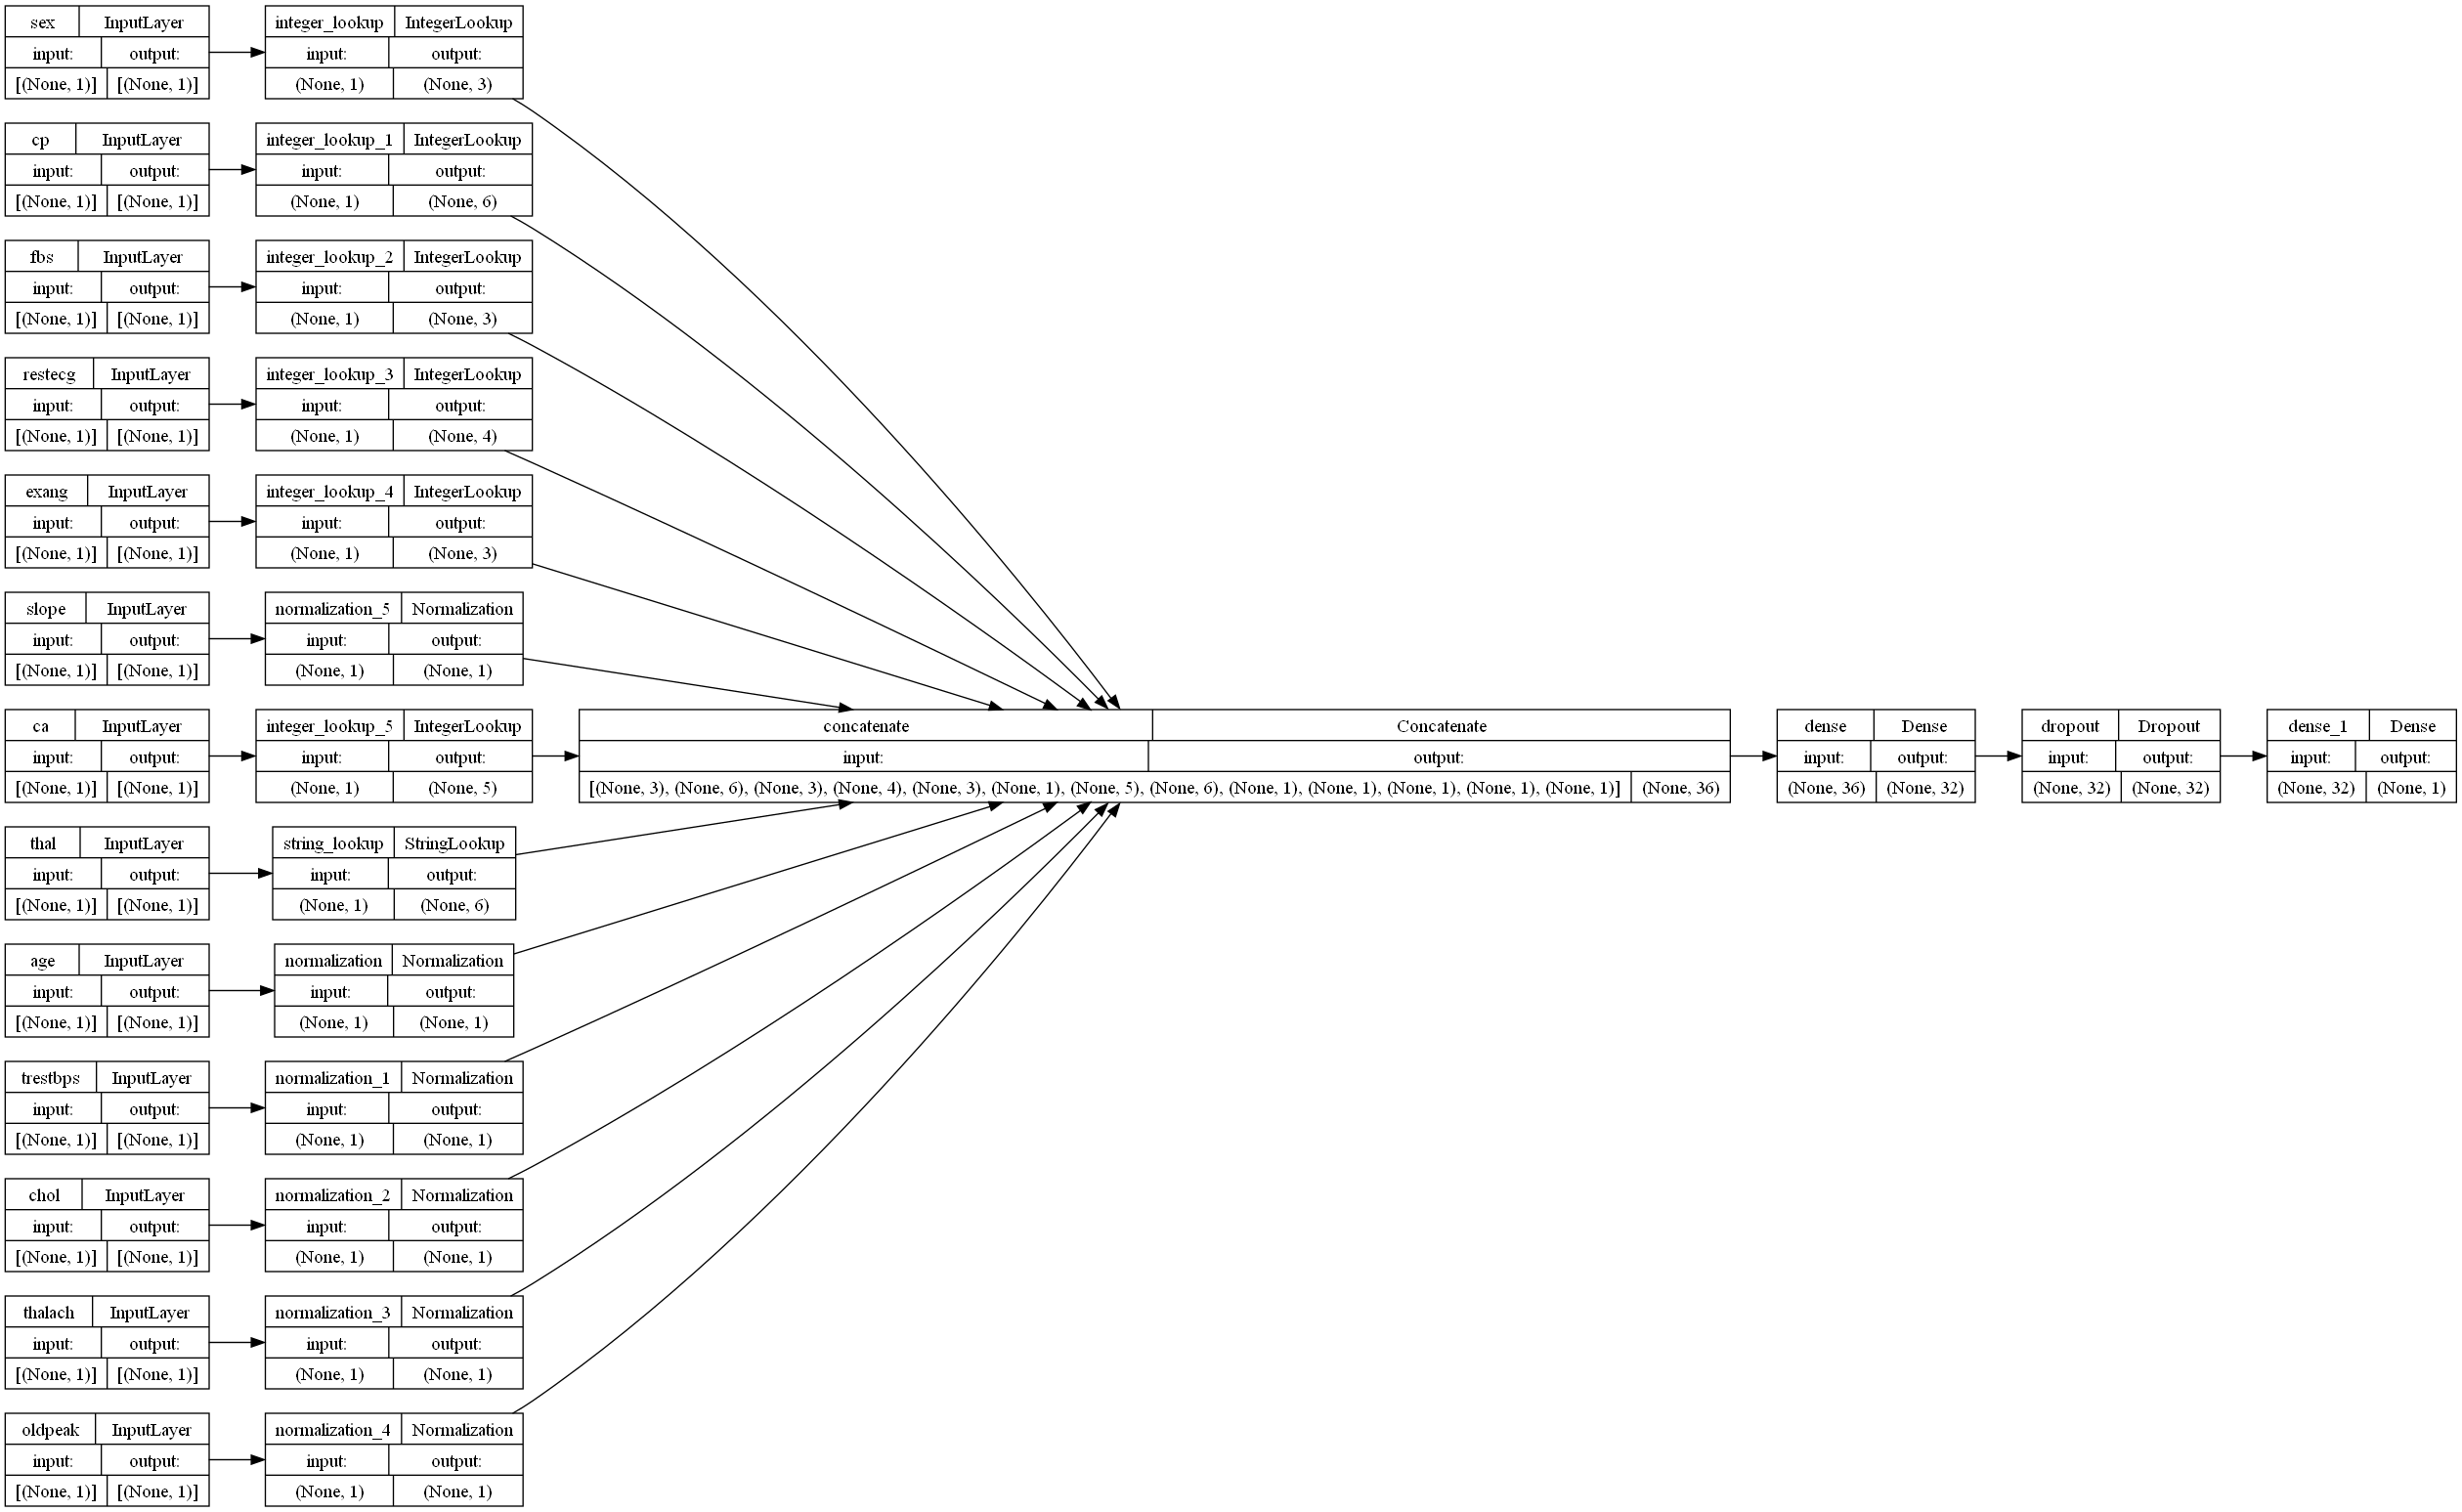

In [14]:
# `rankdir='LR'` es para hacer el grafo horizontal
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [15]:
# Otra manera es visualizarlo con el summary pero en este caso sin usar sequential puede no ser tan informativo
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sex (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 cp (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 fbs (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 restecg (InputLayer)           [(None, 1)]          0           []                               
                                                                                              

### Entrenamos el modelo

In [16]:
model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
8/8 [==============================] - 1s 40ms/step - loss: 0.7278 - accuracy: 0.5331 - val_loss: 0.6528 - val_accuracy: 0.6230
Epoch 2/50
8/8 [==============================] - 0s 6ms/step - loss: 0.6420 - accuracy: 0.6240 - val_loss: 0.6123 - val_accuracy: 0.7541
Epoch 3/50
8/8 [==============================] - 0s 6ms/step - loss: 0.6844 - accuracy: 0.6074 - val_loss: 0.5784 - val_accuracy: 0.8033
Epoch 4/50
8/8 [==============================] - 0s 6ms/step - loss: 0.5993 - accuracy: 0.6818 - val_loss: 0.5485 - val_accuracy: 0.7869
Epoch 5/50
8/8 [==============================] - 0s 6ms/step - loss: 0.6030 - accuracy: 0.6529 - val_loss: 0.5224 - val_accuracy: 0.8197
Epoch 6/50
8/8 [==============================] - 0s 7ms/step - loss: 0.5256 - accuracy: 0.7727 - val_loss: 0.5005 - val_accuracy: 0.8033
Epoch 7/50
8/8 [==============================] - 0s 7ms/step - loss: 0.5233 - accuracy: 0.7521 - val_loss: 0.4814 - val_accuracy: 0.7869
Epoch 8/50
8/8 [=================

Alcanzamos rápidamente una precisión de validación del 80%.


### Inferencia en nuevos datos

Para obtener una predicción para una nueva muestra, simplemente puedes llamar a model.predict(). Solo hay dos cosas que debes hacer:
* envolver los escalares en una lista para tener una dimensión de lote (los modelos solo procesan lotes de datos, no muestras individuales)

* llamar a convert_to_tensor en cada característica

In [17]:
sample = {
    "age": 60,
    "sex": 1,
    "cp": 1,
    "trestbps": 145,
    "chol": 233,
    "fbs": 1,
    "restecg": 2,
    "thalach": 150,
    "exang": 0,
    "oldpeak": 2.3,
    "slope": 3,
    "ca": 0,
    "thal": "fixed",
}

# Tenemos que convertir todo a tensores porque es lo que entiende Keras
input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)

print(
    "Este paciente en particular tiene una probabilidad del %.1f por ciento "
    "of having a heart disease, as evaluated by our model." % (100 * predictions[0][0],)
)

1/1 [==============================] - 0s 221ms/step
Este paciente en particular tiene una probabilidad del 22.0 por ciento of having a heart disease, as evaluated by our model.


# Ejercicio



## Ej 1

Agreguen primero a las metricas (dentro del `compile`) precision y recall. Entrenen nuevamente el mismo modelo y reporten dichas métricas (ver [recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall) y [precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision)). Pueden probar tambien cambiar el optimizador, ver https://keras.io/api/optimizers/:
```
# Instanciar un optimizer
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss=loss, optimizer=opt)
```

In [18]:
# Función auxiliar para crear el modelo y pisar el anterior

def crear_modelo_funcional(inp=all_inputs, out=None, capa_features=all_features, seed=123):
    keras.backend.clear_session()
    # Definir seed Numpy y Keras - solo para replicabilidad
    np.random.seed(seed)
    tf.keras.utils.set_random_seed(seed)
    if out is None:
        hidden1 = layers.Dense(units=32, activation="relu")(capa_features)
        droput1 = layers.Dropout(0.5)(hidden1)
        out = layers.Dense(1, activation="sigmoid")(droput1)

    return keras.Model(inp, out)

In [19]:
## SOLUCION

# Creo de nuevo el modelo para borrar el anterior
model = crear_modelo_funcional()

# Crear un optimizador rmsprop con una tasa de aprendizaje de 0.01 y un factor de descuento (rho) de 0.8
optim = keras.optimizers.RMSprop(learning_rate=0.01, rho=0.8)

# Importamos las metricas que queremos usar
from tensorflow.keras.metrics import Precision, Recall

model.compile(optim, "binary_crossentropy", metrics=["accuracy", Precision(), Recall()])

model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
8/8 [==============================] - 2s 47ms/step - loss: 0.5720 - accuracy: 0.6860 - precision: 0.4632 - recall: 0.6377 - val_loss: 0.3739 - val_accuracy: 0.8033 - val_precision: 0.6000 - val_recall: 0.4286
Epoch 2/50
8/8 [==============================] - 0s 7ms/step - loss: 0.4135 - accuracy: 0.8223 - precision: 0.7600 - recall: 0.5507 - val_loss: 0.3668 - val_accuracy: 0.8525 - val_precision: 0.6667 - val_recall: 0.7143
Epoch 3/50
8/8 [==============================] - 0s 6ms/step - loss: 0.3623 - accuracy: 0.8264 - precision: 0.7143 - recall: 0.6522 - val_loss: 0.3762 - val_accuracy: 0.8197 - val_precision: 0.6000 - val_recall: 0.6429
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.3052 - accuracy: 0.8512 - precision: 0.7705 - recall: 0.6812 - val_loss: 0.3864 - val_accuracy: 0.8525 - val_precision: 0.6471 - val_recall: 0.7857
Epoch 5/50
8/8 [==============================] - 0s 7ms/step - loss: 0.3070 - accuracy: 0.8802 - precision: 0.8030 - r

## Ej 2

Guarden la historia de entrenamiento del modelo de la siguiente manera:
```
# Recorrer los pasos de entrenamiento
for epoch in range(num_epochs):
        history = model.fit(X_train, y_train, batch_size=batch_size)
```
Inspeccionen que se almacena en la variable history, ¿puede graficar una curva de entrenamiento? 

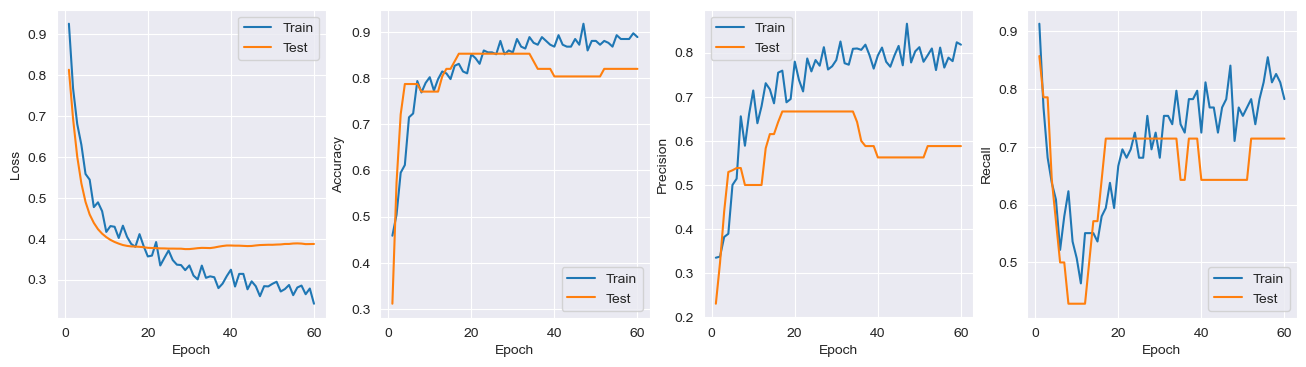

In [20]:
## SOLUCION

# Creo de nuevo el modelo para borrar el anterior
model = crear_modelo_funcional()

# Compilar el modelo con las métricas deseadas
model.compile("adam", "binary_crossentropy", metrics=["accuracy", Precision(), Recall()])

# Crear un dataframe vacío con las columnas correspondientes
df = pd.DataFrame(columns=["epoch", "loss", "accuracy", "precision", "recall","val_loss", "val_accuracy", "val_precision", "val_recall"])

# Entrenar el modelo dentro de un for
num_epochs = 60
for epoch in range(num_epochs):
    # Obtener el resultado de la función fit para una época
    result = model.fit(train_ds, epochs=1, validation_data=val_ds, verbose=0)
    # Extraer los valores de las métricas
    accuracy    = result.history["accuracy"][0]
    precision   = result.history["precision"][0]
    recall      = result.history["recall"][0]
    loss        = result.history["loss"][0]
    val_loss    = result.history["val_loss"][0]
    val_accuracy = result.history["val_accuracy"][0]
    val_precision = result.history["val_precision"][0]
    val_recall = result.history["val_recall"][0]
    # Añadir una fila al dataframe con los valores de las métricas y la época -> warning de deprecated
    #df = df.append({"epoch": epoch+1, "accuracy": accuracy, "precision": precision, "recall": recall, "val_accuracy": val_accuracy, "val_precision": val_precision, "val_recall": val_recall}, ignore_index=True)
    # Crear un dataframe con la fila que quieres añadir
    row = pd.DataFrame({"epoch": [epoch+1], "loss": [loss], "accuracy": [accuracy], "precision": [precision], "recall": [recall], 
                                            "val_loss": [val_loss], "val_accuracy": [val_accuracy], "val_precision": [val_precision], "val_recall": [val_recall]})
    # Usar pd.concat para unirlo al dataframe original
    df = pd.concat([df, row], ignore_index=True)

# Hacer los gráficos con seaborn
fig, ax = plt.subplots(1,4, figsize=(16,4))

sns.lineplot(data=df, x="epoch", y="loss", label="Train", ax=ax[0])
sns.lineplot(data=df, x="epoch", y="val_loss", label="Test",ax=ax[0])
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Epoch")

sns.lineplot(data=df, x="epoch", y="accuracy", label="Train", ax=ax[1])
sns.lineplot(data=df, x="epoch", y="val_accuracy", label="Test",ax=ax[1])
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epoch")

sns.lineplot(data=df, x="epoch", y="precision", label="Train",ax=ax[2])
sns.lineplot(data=df, x="epoch", y="val_precision", label="Test",ax=ax[2])
ax[2].set_ylabel("Precision")
ax[2].set_xlabel("Epoch")

sns.lineplot(data=df, x="epoch", y="recall", label="Train",ax=ax[3])
sns.lineplot(data=df, x="epoch", y="val_recall", label="Test",ax=ax[3])
ax[3].set_ylabel("Recall")
ax[3].set_xlabel("Epoch")
plt.show()


## Ej 3

Experimente cambiando el learning rate, elija al menos 5 valores y grafique las curvas de aprendizajes de dichos modelos.

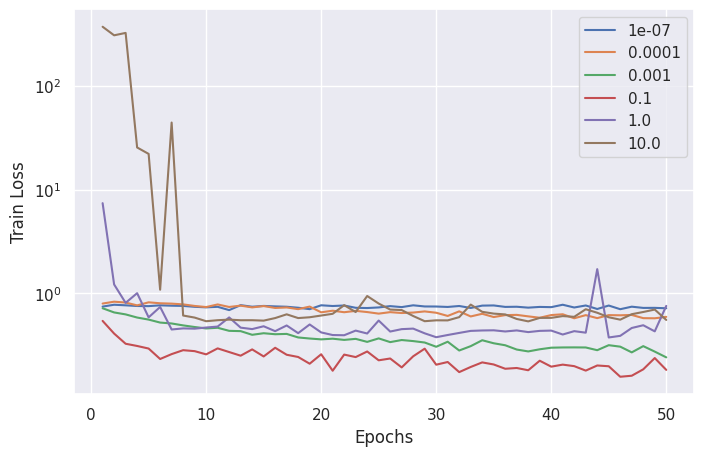

In [ ]:
## SOLUCION

# Seleccionamos distintas tasas de aprendizaje
alphas = np.array([0.0000001, 0.0001, 0.001, 0.1, 1, 10])
num_epochs = 50
def entrenar_modelo(alpha, num_epochs=num_epochs):
    keras.backend.clear_session()
    model = crear_modelo_funcional()
    # Crear un optimizador rmsprop con una tasa de aprendizaje de 0.01 y un factor de descuento (rho) de 0.8
    optim = keras.optimizers.Adam(learning_rate=alpha)
    model.compile(optim, "binary_crossentropy", metrics=["accuracy"])
    history = model.fit(train_ds, epochs=num_epochs, validation_data=val_ds, verbose=0)
    return history

# Hagamos ahora el grafico
sns.set(style="darkgrid")
fig, ax = plt.subplots(1,1,figsize=(8,5))
for i, alpha in enumerate(alphas):
    resultados = entrenar_modelo(alpha)
    # Extrae las métricas de rendimiento del historial
    train_loss = resultados.history['loss']
    # Crea un dataframe con las métricas de rendimiento
    metrics = pd.DataFrame({'Alpha':alpha,'Train Loss': train_loss, 'Epochs':range(1,num_epochs+1)})
    sns.lineplot(x='Epochs', y='Train Loss', data=metrics, ax=ax, label=alpha)

# Usas la escala logaritmica para el eje y
ax.set_yscale('log')
plt.legend()
plt.show()

## Ej 4

Cree un nuevo modelo en el cual utilice al menos dos capas densas, cambie la función de activación. Comparelo con los modelos anteriores.

In [ ]:
## SOLUCION

def instanciar_y_entrenar_modelo(outputs = None, features=all_features, inputs=all_inputs, num_epochs=100):
    keras.backend.clear_session()
    # Le permitimos pasarle la arquitectura, pero sino la pasamos contruimos una por defecto
    if outputs == None:
        hidden1 = layers.Dense(units=32, activation="relu")(features)
        droput1 = layers.Dropout(0.3)(hidden1)
        hidden2 = layers.Dense(units=16, activation="relu")(droput1)
        droput2 = layers.Dropout(0.3)(hidden2)
        new_output = layers.Dense(1, activation="sigmoid")(droput2)
    else:
        new_output = outputs
        
    model = crear_modelo_funcional(out=new_output)
    # Crear un optimizador rmsprop con una tasa de aprendizaje de 0.01 y un factor de descuento (rho) de 0.8
    optim = keras.optimizers.Adam()
    model.compile(optim, "binary_crossentropy", metrics=["accuracy", Precision(), Recall()])
    history = model.fit(train_ds, epochs=num_epochs, validation_data=val_ds, verbose=1)
    
    return history

In [ ]:
history = instanciar_y_entrenar_modelo()

Epoch 1/100
8/8 [==============================] - 2s 70ms/step - loss: 0.7128 - accuracy: 0.5165 - precision: 0.3125 - recall: 0.5797 - val_loss: 0.6459 - val_accuracy: 0.7213 - val_precision: 0.4000 - val_recall: 0.4286
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 0.6473 - accuracy: 0.6488 - precision: 0.3947 - recall: 0.4348 - val_loss: 0.5832 - val_accuracy: 0.8033 - val_precision: 0.7500 - val_recall: 0.2143
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 0.6110 - accuracy: 0.6281 - precision: 0.3158 - recall: 0.2609 - val_loss: 0.5334 - val_accuracy: 0.8197 - val_precision: 1.0000 - val_recall: 0.2143
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 0.5835 - accuracy: 0.6860 - precision: 0.4146 - recall: 0.2464 - val_loss: 0.4943 - val_accuracy: 0.8197 - val_precision: 1.0000 - val_recall: 0.2143
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 0.5508 - accuracy: 0.7438 - precision: 0.629

## Ej 5

Cree un nuevo modelo igual al primero donde no utilice Dropout. Comparelo con los modelos anteriores. Puede también experimentar cambiando el valor de Dropout, ¿que efectos en las métricas puede ver sobre el modelo?

In [ ]:
## SOLUCION

# Nueva red sin Dropout
hidden1 = layers.Dense(units=32, activation="relu")(all_features)
hidden2 = layers.Dense(units=16, activation="relu")(hidden1)
new_output = layers.Dense(1, activation="sigmoid")(hidden2)

history = instanciar_y_entrenar_modelo(outputs = new_output)

Epoch 1/100
8/8 [==============================] - 3s 72ms/step - loss: 0.8896 - accuracy: 0.2727 - precision: 0.2464 - recall: 0.7536 - val_loss: 0.8428 - val_accuracy: 0.3115 - val_precision: 0.1667 - val_recall: 0.5000
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 0.7433 - accuracy: 0.4298 - precision: 0.2621 - recall: 0.5507 - val_loss: 0.7122 - val_accuracy: 0.4590 - val_precision: 0.0870 - val_recall: 0.1429
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 0.6297 - accuracy: 0.6736 - precision: 0.3958 - recall: 0.2754 - val_loss: 0.6204 - val_accuracy: 0.6557 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 0.5580 - accuracy: 0.7314 - precision: 0.6667 - recall: 0.1159 - val_loss: 0.5554 - val_accuracy: 0.7541 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/100
8/8 [==============================] - 0s 5ms/step - loss: 0.5070 - accuracy: 0.7314 - 